**Exploratory data analysis** 

    Analiza el conjunto de datos con el objetivo de resumir sus características principales, generalmente a través de medios visuales. 
    La finalidad es ver que pueden decirnos los datos más alla del modelado formal o las pruebas de hipótesis
    

Fuente: https://en.wikipedia.org/wiki/Exploratory_data_analysis

Data Mining de la muestra extraida de Twitter. Es muy probable que con el paso del tiempo debido a la ampliación de necesidades se incremente la muestra. 

Al obtener el dataset ya se hicieron algunos pasos de data mining como: 

* Supresión de cuentas a las que hace referencia (@XXXX) y aglutinación de múltiples espacios en uno
* Eliminación de páginas web (http,https y www) (str.replace('http\S+|www.\S+', '', case=False))
* Eliminación del símbolo # que hace referencia a los hastag
* Supresión de comentarios duplicados una vez que se elimina todo lo anterior

Este dataset contiene lenguaje tóxico que es el que se está analizando. 

In [1]:
import pandas as pd
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
import numpy as np
from emoji import UNICODE_EMOJI
from nltk import bigrams 

%matplotlib inline

# Lectura de la muestra

In [2]:
df = pd.read_csv("../00_Dataset/data_sentiment_labels_completo.csv", sep=';',usecols=[0,1])
df.iloc[597,:]

texto     _ Es un bicho si, pero 29 años o casi. Mucha p...
toxico                                                    0
Name: 597, dtype: object

# Data Cleaning 

**1) Eliminación de todas las palabras que empiecen por '_' ya que no nos dan información. **

*_Zaragoza_ Cállese burro, lea libros y tuitee menos, botarate. ;1;*

In [3]:
#Función que elimina la palabra que empiece por el caracter (char) en el texto(text)
def delete_starting_with(text, char):
    text=' '.join(word for word in text.split(' ') if not word.startswith(char))
    return text

In [4]:
df['texto']=df['texto'].apply(lambda txt: delete_starting_with(txt, '_') )
df['texto']=df['texto'].replace('_','')
df.iloc[597,:]

texto     Es un bicho si, pero 29 años o casi. Mucha pas...
toxico                                                    0
Name: 597, dtype: object

**2) Eliminación de las comillas y guiones —. **

*"""Tú eres tan cabrón que los estás jodiendo"" ""Que pongan el aire más alto así nos infectamos"" ""Estos hijos de puta se tienen que ir a su país"" ""Que esto es España joder"" ""Dentro de poco esto va a estar lleno de ratas y nos vamos a infectar todos"" ""Me están tocando los huevos"""*

In [5]:
df['texto']=df.texto.apply(lambda x: x.replace('\"','')) 
df['texto']=df.texto.apply(lambda x: x.replace('—','')) 
df.iloc[147,:]

texto     Tú eres tan cabrón que los estás jodiendo Que ...
toxico                                                    1
Name: 147, dtype: object

# Análisis

** Descripción general del dataset**

In [6]:
#Dimensiones del corpus obtenido de Twitter sobre lenguaje tóxico
print("Número de filas : "+str(df.shape[0]))
print("Número de columnas : "+str(df.shape[1]))

Número de filas : 705
Número de columnas : 2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 2 columns):
texto     705 non-null object
toxico    705 non-null int64
dtypes: int64(1), object(1)
memory usage: 11.1+ KB


Donde se puede ver que no hay ningún valor a nulo. gracias a reconocerlos con: 

In [8]:
df[df.isnull().any(axis=1)].head()

,texto,toxico


** Cuenta del número de signos de admiración en mayúsculas como signo de exaltación. **

*ENTRETÉNME, PAYASO!!!... *

In [9]:
#Creación de la columna que cuenta el número de veces que aparece un símbolo
df['num_admir']=df.texto.apply(lambda txt: txt.count('!') )

In [10]:
df.iloc[338,:]

texto        ENTRETÉNME, PAYASO!!!... 
toxico                               1
num_admir                            3
Name: 338, dtype: object

**Cuenta del número de palabras en mayúsculas como signo de exaltación. **

*ENTRETÉNME, PAYASO!!!... *

In [11]:
regex = r"\B[A-Z]+\b"
frase = "Que Valls será un mierdaseca, que nadie lo discute, pero que está ofreciendo sus votos GRATIS CHABALADA. No he visto todavía a la derecha catalana hacer lo mismo"

In [12]:
#Búsqueda las palabras en mayúsculas a través de una expresión regular
df['num_may']=df.texto.apply(lambda txt: len(list(re.finditer(regex, txt))) )
#Se escala el número de mayúsculas respecto del total del tweet
df['num_may_esc']=df.texto.apply(lambda txt: len(list(re.finditer(regex, txt)))/len(txt.split()))

df.iloc[342,:]

texto          Cabeza de alcornoque
toxico                            1
num_admir                         0
num_may                           0
num_may_esc                       0
Name: 342, dtype: object

**Tokenización de los textos. **

In [13]:
#Elminamos los espacios duplicados 
df['texto']=df.texto.apply(lambda txt: re.sub(' +', ' ',txt) )
#Convertimos en tokens las frases 
df['series_token']=df.texto.apply(lambda txt: word_tokenize(txt))
df['series_token'].head()

0                            [La, etiqueta, ,, cabrón]
1    [Hasta, que, un, cabron, trata, a, la, lacra, ...
2                [La, edad, no, la, pones, eh, cabrón]
3    [Y, de, un, cabron, solo, puedes, obtener, cab...
4    [Eres, más, guiri, que, los, irlandeses, de, a...
Name: series_token, dtype: object

** Cuenta del número de emoticonos . **


In [14]:
import emoji
def extract_emojis(str):
  return ' '.join(c for c in str if c in emoji.UNICODE_EMOJI)

In [15]:
df['emojis']=df['texto'].apply(lambda txt: extract_emojis(txt))

In [16]:
df['num_emoji']=df[df.emojis != '']['emojis'].apply(lambda txt: int(len(txt.split(' '))))
df.num_emoji=df.num_emoji.fillna(0)
df.num_emoji=df.num_emoji.astype(int)
df.num_emoji.iloc[1]

0

In [17]:
aux=df[df.num_emoji != 0]['emojis'].tolist()
set(aux)

{'™',
 '♥',
 '⛰ 🌳',
 '❤',
 '🌌 🚶 ♀ 🚶 ♂ 🏁',
 '🍰 🍧',
 '🍸',
 '🎵',
 '🎼 😊 👍',
 '🏊 ♀ 🏊 ♂',
 '👉',
 '👌 👏 🏊 ♂',
 '👍',
 '👏',
 '👶 🌍',
 '💡',
 '💯 😍 😘 🤣',
 '📣',
 '📲 📲',
 '🔊',
 '🔝',
 '🔵',
 '🗝 🏠 👏 👥',
 '😀',
 '😂',
 '😂 😂 😂 😂',
 '😅',
 '😉',
 '😊',
 '😍 🌴',
 '😎',
 '😎 🌴',
 '😐',
 '😒',
 '😓',
 '😠',
 '😠 😡 😠',
 '😡',
 '😩',
 '😪',
 '😫',
 '😫 😫',
 '😭',
 '😭 😭 😭 😭',
 '🙄',
 '🙄 🙄',
 '🙆',
 '🤣 🐷 🤣 🐷 🤣 🐷 🤣 🐷 🤣 🐷 🤣 🐷 🤣',
 '🤤 😍',
 '🤤 🤤'}

**Label del número de palabras identificadas como tóxicas en en corpus **

In [18]:
import re
from unicodedata import normalize
# necesitamos quitar los acentos y las diéresis para no sustituir palabras como moño a mono (no podemos utilizar la libreia unicode)
#Pasamos todo el texto a minúsculas
#Quitamos acentos y diéresis 
def estandarizacion(string):
    res=string.lower()
    res=re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", normalize( "NFD", res), 0, re.I)
    res=normalize( 'NFC', res)
    return res


In [19]:
### Librería de insultos
# Obtenida de https://listas.20minutos.es/lista/insultos-en-castellano-que-deberias-conocer-y-su-significado-393340/
path_lib_insultos="../00_Dataset/libreria_insultos.txt"

In [20]:
# Lectura de la anterior librería
with open(path_lib_insultos, encoding='utf8') as f:
    lista_insultos = f.read().splitlines()

# Supresión de mayúsculas y acentos debido a que en las redes sociales es muy común no utilizarlos. 
estand_lib_ins = []
for i in lista_insultos:
    estand_lib_ins.append(estandarizacion(i))

In [21]:
#Obtenemos un label con la cantidad de veces que aparece una palabra considerada como tóxica. 
def num_insultos(texto): 
    return len([word for word in texto.split() if word in estand_lib_ins])

In [22]:
df['num_insultos']=df['texto'].apply(lambda txt: num_insultos(estandarizacion(txt)))


In [23]:
df[df.num_insultos == 2]

,texto,toxico,num_admir,num_may,num_may_esc,series_token,emojis,num_emoji,num_insultos
18,"TE QUIERO DISPARAR JODER, TODOS LOS PUTOS BESO...",1,0,35,1.0,"[TE, QUIERO, DISPARAR, JODER, ,, TODOS, LOS, P...",,0,2
47,Tu que eres un parguela y seguramente un niñat...,1,0,0,0.0,"[Tu, que, eres, un, parguela, y, seguramente, ...",,0,2
147,Tú eres tan cabrón que los estás jodiendo Que ...,1,0,0,0.0,"[Tú, eres, tan, cabrón, que, los, estás, jodie...",,0,2
159,Salía del aeropuerto con mis compañeros y un p...,1,0,0,0.0,"[Salía, del, aeropuerto, con, mis, compañeros,...",,0,2
256,Hay que ser capullo para escribir eso. Yo no v...,1,0,0,0.0,"[Hay, que, ser, capullo, para, escribir, eso, ...",,0,2
261,Puto niño zampabollos,1,0,0,0.0,"[Puto, niño, zampabollos]",,0,2
292,Jajajaja aprende a escribir puto cazurro,1,0,0,0.0,"[Jajajaja, aprende, a, escribir, puto, cazurro]",,0,2
357,Es un vil pelele y fantoche,1,0,0,0.0,"[Es, un, vil, pelele, y, fantoche]",,0,2
359,Tan nazi que le dijo pelele a hitler,1,0,0,0.0,"[Tan, nazi, que, le, dijo, pelele, a, hitler]",,0,2
366,Puto Amunike menudo pichabrava,1,0,0,0.0,"[Puto, Amunike, menudo, pichabrava]",,0,2


**A quién va dirigido **

In [24]:
# Definición de la función que identificará si las frase es no incluyente
lista=['eres',"es", 'son', 'sois']# Uno de los atrones comunes cuando se insulta es utilizar el verbo ser no incluyente

def otra_persona(texto):
    res=0
    for elem in lista: 
        if(texto.find(elem) != -1 ): res=1
    return res


In [25]:
#Creación de la columna que comprueba la no unclisuión de la primera persona
df["dir_23ps"]=df.texto.map(lambda txt:otra_persona(txt) )

In [26]:
#Comprobación
set(df["dir_23ps"].tolist())

{0, 1}

** Nivel de toxicidad a través de los emoticonos**

fuente de la librería: http://kt.ijs.si/data/Emoji_sentiment_ranking/

 Se modifican algunos como -0.017;👪||  -0.313;🍱 || -0.486;🔋|| -0.033;☠ || -0.348;👮|| -0.15;💂 || -0.333;🍈 por no estar de acuerdo con su indicador negativo

In [27]:
path_lib_emoji="../00_Dataset/Libraries_Emojis_sent.csv"
df_train = pd.read_csv(path_lib_emoji, sep=';')
df_train_aux=df_train[['sent', 'emojis']]

#Convertimos la lista del csv a diccionario para poder asirnarle en peso 
diccionario_neg=df_train_aux.set_index('emojis').T.to_dict('dict')

#Prueba
diccionario_neg.get('😠')['sent']

-0.299

In [28]:
#Sumammos de acuerdo al diccionario todos los emoticonos que aparecen en la frase con su nivel de negatividad
def score_total_toxic(text):
    suma=[]
    try:
        suma=[diccionario_neg.get(value)['sent'] for value in text.split() ]
        res=sum(float(i) for i in suma)/len(suma)
    except: 
        res=0
    return res

In [29]:
#Creación de la columna de nivel de toxicidad
df["score_emoji_tox"]=df.emojis[df.emojis !=''].map(lambda x: score_total_toxic(x))
df["score_emoji_tox"]=df.score_emoji_tox.fillna(0)

In [30]:
#Definimos como criterio de énfasis positivo o negativo a:
#Porcentaje de palabras en mayúsculas
#Que sea una cetgorización mediante el verbo ser como: "Tu eres un", "Es que son unos"
#Número de admiraciones eres un imbécil !!!!!!

df['emphasize']=df['num_admir']+df['num_may_esc']+df['dir_23ps']
df.iloc[38, :]


texto              Asco de periodismo y cadena perroflauta, miser...
toxico                                                             1
num_admir                                                          0
num_may                                                            0
num_may_esc                                                        0
series_token       [Asco, de, periodismo, y, cadena, perroflauta,...
emojis                                                         😠 😡 😠
num_emoji                                                          3
num_insultos                                                       0
dir_23ps                                                           1
score_emoji_tox                                            -0.332333
emphasize                                                          1
Name: 38, dtype: object

# Análisis

**Representación de las categorías **

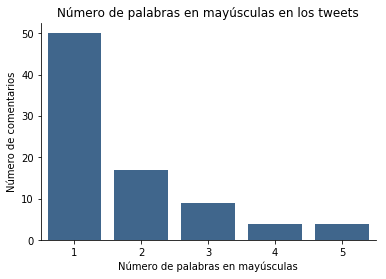

In [31]:
#Representación del número de palabras en mayúsuclas
#Se elimina el 0 por no ser siginificativo
dy = sns.countplot(data=df, x='num_may',color=(0.2, 0.4, 0.6),order = list(range(df.num_may.min()+1,6)))
dy.set(xlabel='Número de palabras en mayúsculas', ylabel = 'Número de comentarios')
dy.spines['top'].set_color('none')
dy.spines['right'].set_color('none')
plt.title('Número de palabras en mayúsculas en los tweets')
plt.show()

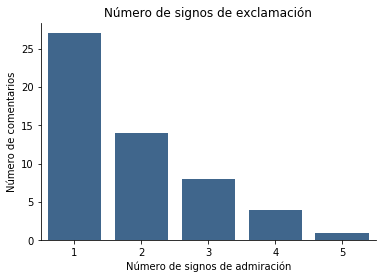

In [32]:
#Representación del número de palabras en mayúsuclas
#Se elimina el 0 por no ser siginificativo
dy = sns.countplot(data=df, x='num_admir',color=(0.2, 0.4, 0.6),order = list(range(df.num_admir.min()+1,6)))
dy.set(xlabel='Número de signos de admiración', ylabel = 'Número de comentarios')
dy.spines['top'].set_color('none')
dy.spines['right'].set_color('none')
plt.title('Número de signos de exclamación')
plt.show()

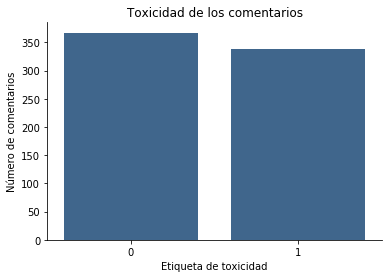

In [33]:
#Representación del número de palabras etiquetadas como tóxicas
dy = sns.countplot(data=df, x='toxico',color=(0.2, 0.4, 0.6))
dy.set(xlabel='Etiqueta de toxicidad', ylabel = 'Número de comentarios')
dy.spines['top'].set_color('none')
dy.spines['right'].set_color('none')
plt.title('Toxicidad de los comentarios')
plt.show()

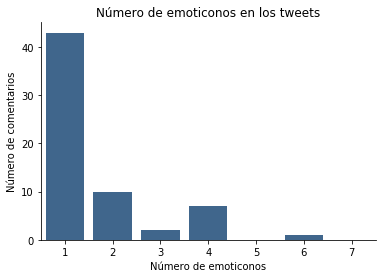

In [34]:
#Representación del número de palabras en mayúsuclas
#Se elimina el 0 por no ser siginificativo
dy = sns.countplot(data=df, x='num_emoji',color=(0.2, 0.4, 0.6),order = list(range(df.num_emoji.min()+1,8)))
dy.set(xlabel='Número de emoticonos', ylabel = 'Número de comentarios')
dy.spines['top'].set_color('none')
dy.spines['right'].set_color('none')
plt.title('Número de emoticonos en los tweets')
plt.show()

# Wordcloud

Da una idea generak sobre cuales son las palabras que tienen mas presencia en nuestro corpus. 

In [35]:
forb=stopwords.words('spanish')
forb.remove('no')
forb.append("si")
forb.append("va")
forb.append("el")
forb.append("besugo")
forb.append("bien")

type(forb)

list

In [36]:
dfwc=df
#Supresión de las stopword en castellano
dfwc['filtered_words']=dfwc.texto.apply(lambda frase: [word.lower() for word in frase.split(' ') if word.lower() not in forb])
#Separación del dataframe en dataframe con lenguaje tóxico y dataframe sin lenguaje tóxico
df_pos=dfwc[dfwc.toxico == 0]
df_neg=dfwc[dfwc.toxico == 1]
#Conversión de la lista de listas a una sola lista con todas las palabras
slist_pos = [st for row in df_pos.filtered_words for st in row]
slist_neg = [st for row in df_neg.filtered_words for st in row]

In [37]:
#De lista a un string completo
neg_string = ' '.join(slist_neg)
pos_string = ' '.join(slist_pos)

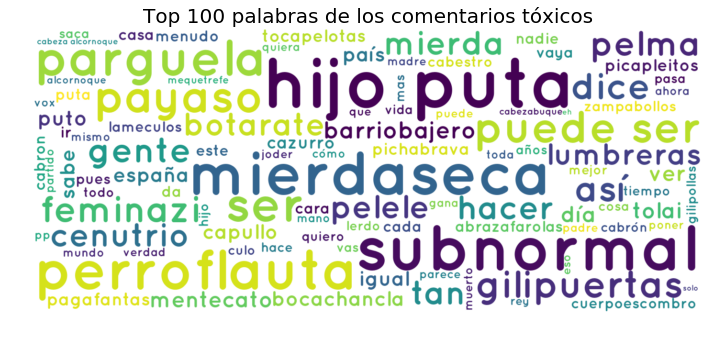

In [38]:
# Wordcloud de las palabras con significado negativo
wordcloud = WordCloud(width=1400, height=600, max_words=100, \
                      max_font_size=150,\
                      background_color="white",\
                      font_path='../03_Exploratory_Data_Analysis/Quicksand-Bold.otf').generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Top 100 palabras de los comentarios tóxicos', fontsize=20)
plt.show()

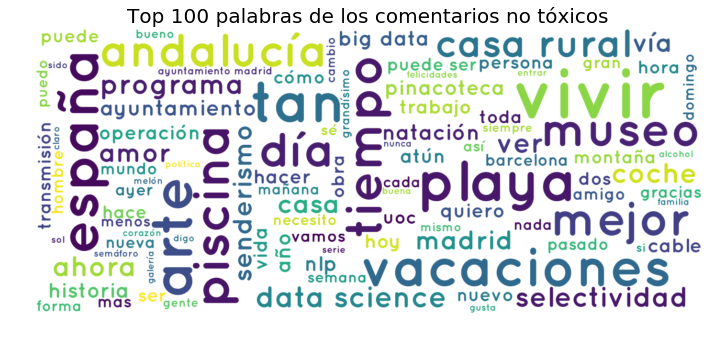

In [39]:
# Wordcloud de las palabras con significado no tóxico
wordcloud = WordCloud(width=1400, height=600, max_words=100, \
                      max_font_size=150,\
                      background_color="white",\
                      font_path='C:/Users/Esperanza/Desktop/UOC/TFM/python/03_Exploratory_Data_Analysis/Quicksand-Bold.otf').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Top 100 palabras de los comentarios no tóxicos', fontsize=20)

plt.show()

** Bigram**

Debido a  que el orden de las palabras es importante, se comprobará si hay alguno tipo de relación con las palabras que están una junta otra. 

Esta función toma una lista de tokens y produce una lista de tuplas con las palabrasque comunmente aparecen una junto a otra. 

In [40]:
import nltk, re, string, collections
from nltk.util import ngrams # function for making ngrams
preposiciones=['a','ante','bajo','cabe','con','contra','de','desde','en','entre','hacia','hasta','para','por','según','sin','so','sobre','tras']
conjunciones=['y', 'en', 'ni', 'o', 'u','mas', 'pero', 'sin embargo', 'no obstante', 'a pesar de', 'aunque']
stop= ['de', 'la','a','en', 'el','y', 'es', 'un','lo','que']
punt= [',', '.']
stop=stop+preposiciones+conjunciones


In [41]:
#Se toma la columna con los textos y se convierte a un string individual if not  if c in
uniendo=[]
[uniendo.append(row+' ') for row in df.texto ]
un_string=','.join(uniendo)
# No se quita mediante stopwords porque hay algunos incluidos en esa lista que se necesitan
un_string=un_string.replace('?', '').replace('¿', '').replace('.', '').replace('', '')\
                    .replace(',', '').replace('!', '').replace('¡', '').replace('”', '').replace('“', '')
res=[word.lower() for word in un_string.split(' ') if word not in stop ]

In [42]:
res_ngram = ngrams(res, 3)
# Se crea un diccionario collections.Counter que permitirá contras, ver el mínimo el máximo ...
esBigramFreq = collections.Counter(res_ngram)
esBigramFreq.most_common(10)

[(('no', 'se', 'puede'), 12),
 (('se', 'puede', 'ser'), 12),
 (('puede', 'ser', 'más'), 10),
 (('', '', ''), 10),
 (('hijo', 'de', 'puta'), 4),
 (('data', 'science', ''), 4),
 (('este', 'hijo', 'puta'), 3),
 (('hijo', 'puta', ''), 3),
 (('', 'ofertas', 'trabajo'), 3),
 (('que', 'hijo', 'puta'), 2)]

No concluyente, no nos proporciona más información

**Corrrelación**

Definida como la asociación/ relación entre variables.

 ** *Covarianza:*  ** Nos puede ayudar a calcular la posible correlación lineal entre las observaciones de dos variables cuantitativas. Primero, cada variable se centra restando su media. Estas puntuaciones centradas se multiplican juntas para medir si el aumento en una variable se asocia con el aumento en otra. Finalmente, el valor esperado (E) del producto de estas puntuaciones centradas se calcula como un resumen de la asociación. Intuitivamente, el producto de las puntuaciones centradas se puede considerar como el área de un rectángulo con la distancia de cada punto de la media que describe un lado del rectángulo. 
                        $$Cov(X, Y) = E $$
                        
El problema con la covarianza es que mantiene la escala de las variables X e Y, y por lo tanto puede tomar cualquier valor. Esto dificulta la interpretación y es imposible comparar covarianzas entre sí. Por ejemplo, Cov (X, Y) = 5.2 y Cov (Z, Q) = 3.1 nos dicen que estos pares están asociados positivamente, pero es difícil decir si la relación entre X e Y es más fuerte que Z y Q sin mirar A los medios y distribuciones de estas variables. Aquí es donde la correlación se vuelve útil: al estandarizar la covarianza mediante alguna medida de variabilidad en los datos, produce una cantidad que tiene interpretaciones intuitivas y una escala consistente.

Fuente: https://www.datascience.com/blog/introduction-to-correlation-learn-data-science-tutorials


**Coeficiente de correlación de Pearson**

** * Pearson* ** es el coeficiente de correlación más usado para medir la asociación entre variables CONTINUAS. Cuantifica el grado en el que la relación entre dos variables puede ser decrita por una linea. 

$$ \rho_{X,Y} = \frac{E[(X-\mu_{X})(Y-\mu_{Y})] }{\sigma_{X}\sigma_{Y}}$$

Cuanto más esté ρ a 1, más dependencia hay entre las dos variables y el incremento en una variable resulta en el incremento en otra mientras que si ρ está  cercano a -1 significará que si una varible decrementa resulta en el incremento de la otra variables. 



In [43]:
df.drop(['filtered_words','emojis', 'texto'], axis=1).corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)


,toxico,num_admir,num_may,num_may_esc,num_emoji,num_insultos,dir_23ps,score_emoji_tox,emphasize
toxico,1.0,0.11,-0.045,-0.051,-0.051,0.56,-0.028,-0.13,0.069
num_admir,0.11,1.0,0.0085,0.067,-0.00019,-0.036,0.0058,0.035,0.84
num_may,-0.045,0.0085,1.0,0.78,-0.023,0.018,-0.048,-0.00045,0.072
num_may_esc,-0.051,0.067,0.78,1.0,-0.028,-0.041,-0.11,-0.0068,0.11
num_emoji,-0.051,-0.00019,-0.023,-0.028,1.0,-0.021,0.0041,0.26,-0.0012
num_insultos,0.56,-0.036,0.018,-0.041,-0.021,1.0,-0.026,-0.094,-0.049
dir_23ps,-0.028,0.0058,-0.048,-0.11,0.0041,-0.026,1.0,0.0059,0.54
score_emoji_tox,-0.13,0.035,-0.00045,-0.0068,0.26,-0.094,0.0059,1.0,0.031
emphasize,0.069,0.84,0.072,0.11,-0.0012,-0.049,0.54,0.031,1.0


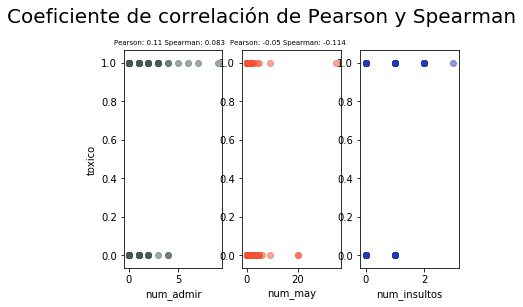

In [44]:
# plot correlated values
#plt.rcParams['figure.figsize'] = [16, 6]

fig, ax = plt.subplots(nrows=1, ncols=3)

ax=ax.flatten()

cols = ['num_admir', 'num_may', 'num_insultos' ]
colors=['#415952', '#f35134', '#243AB5', '#243AB5']
j=0

for i in ax:
    if j==0:
        i.set_ylabel('toxico')
    i.scatter(df[cols[j]], df['toxico'],  alpha=0.5, color=colors[j])
    i.set_xlabel(cols[j])
    i.set_title('Pearson: %s'%df.corr().loc[cols[j]]['toxico'].round(2)+' Spearman: %s   '%df.corr(method='spearman').loc[cols[j]]['toxico'].round(3), fontsize=7)
    j+=1

plt.title('Coeficiente de correlación de Pearson y Spearman', fontsize=20, y=1.10, x=-1)
plt.show()

# Guardar como csv


In [45]:
df.to_csv('../00_Dataset/clean_sentiment_labels_completo.csv', sep=';', index=False)

# Tokens con más apariciones 

In [46]:
from keras.preprocessing.text import Tokenizer
import collections

NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  

tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(df.series_token)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

C:\Users\Esperanza\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Fitted tokenizer on 705 documents
10000 words in dictionary
Top 5 most common words are: [('de', 476), (',', 428), ('.', 410), ('que', 321), ('la', 281)]


In [47]:
df.head()

,texto,toxico,num_admir,num_may,num_may_esc,series_token,emojis,num_emoji,num_insultos,dir_23ps,score_emoji_tox,emphasize,filtered_words
0,"La etiqueta, cabrón",1,0,0,0.0,"[La, etiqueta, ,, cabrón]",,0,1,0,0.0,0.0,"[etiqueta,, cabrón]"
1,Hasta que un cabron trata a la lacra cómo se d...,1,0,0,0.0,"[Hasta, que, un, cabron, trata, a, la, lacra, ...",,0,1,0,0.0,0.0,"[cabron, trata, lacra, cómo, debe, indignan]"
2,La edad no la pones eh cabrón,1,0,0,0.0,"[La, edad, no, la, pones, eh, cabrón]",,0,1,1,0.0,1.0,"[edad, no, pones, eh, cabrón]"
3,Y de un cabron solo puedes obtener cabronadas,1,0,0,0.0,"[Y, de, un, cabron, solo, puedes, obtener, cab...",,0,1,1,0.0,1.0,"[cabron, solo, puedes, obtener, cabronadas]"
4,Eres más guiri que los irlandeses de aquí cabr...,1,0,1,0.1,"[Eres, más, guiri, que, los, irlandeses, de, a...",,0,1,1,0.0,1.1,"[guiri, irlandeses, aquí, cabrón, xd]"


Cosas que sigo queriendo hacer: 
    https://marcobonzanini.com/2015/04/01/mining-twitter-data-with-python-part-5-data-visualisation-basics/ 
        (Preparion for data visualisation)
        que pareece que es lo mismo que el final de https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-2-333514854913
DISPARARRRRR a disparar 
insertar emoticons_happy y emoticons_sad

In [48]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

In [49]:
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S',':(',":'(", '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])